# 階層ベイズモデル 負の二項分布

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import jax
import pymc as pm
import arviz as az
import xarray as xr
from patsy import dmatrix

In [2]:
filepath = "../../../../../data/processed/df_filtered_5years.xlsx"
df = pd.read_excel(filepath)
df = df.dropna()

## 変数の定義

In [3]:
population = df['population']
bridge = df['dummy_after_bridge_opened']
income = df['income']
log_income = np.log(income)
area = df['area_km2']
log_area = np.log(area)
distance = df['distance_m']
log_distance = np.log(distance)

formula = 'log_income + log_area + log_distance'
group_var = 'island_id'

X = dmatrix(formula, data=df, return_type='dataframe')

islands = pd.Categorical(df['island_id'])
islands_codes = islands.codes
n_islands = len(islands.categories)

year = pd.Categorical(df['year'])
year_codes = year.codes
n_years = len(year.categories)

# 過分散パラメータを求める
mean_population = np.mean(population)
var_population = np.var(population)
alpha = (var_population - mean_population) / mean_population**2

## モデルの定義

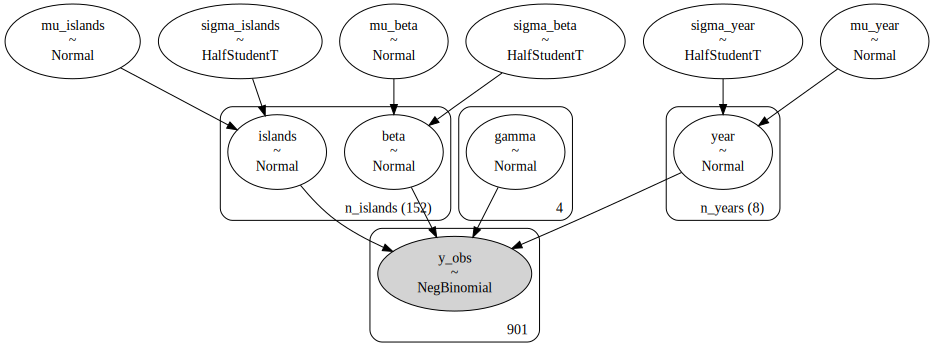

In [5]:
# モデルの定義
with pm.Model() as model:
    # グループ毎の事前分布
    mu_beta = pm.Normal('mu_beta', mu=0, sigma=100)
    sigma_beta = pm.HalfStudentT('sigma_beta', nu=4, sigma=100)
    beta = pm.Normal('beta', mu=mu_beta, sigma=sigma_beta, shape=n_islands, dims='n_islands')

    gamma = pm.Normal('gamma', mu=0, sigma=100, shape=X.shape[1])

    mu_islands = pm.Normal('mu_islands', mu=0, sigma=100)
    sigma_islands = pm.HalfStudentT('sigma_islands', nu=4, sigma=100)
    islands = pm.Normal('islands', mu=mu_islands, sigma=sigma_islands, shape=n_islands, dims='n_islands')

    mu_year = pm.Normal('mu_year', mu=0, sigma=100)
    sigma_year = pm.HalfStudentT('sigma_year', nu=4, sigma=100)
    year = pm.Normal('year', mu=mu_year, sigma=sigma_year, shape=n_years, dims='n_years')


    # 線形予測子
    mu = beta[islands_codes] * bridge + pm.math.dot(X, gamma) + islands[islands_codes] + year[year_codes]
    theta = pm.math.exp(mu)

    # 尤度関数（負の二項分布）
    y_obs = pm.NegativeBinomial('y_obs', mu=theta, alpha=alpha, observed=population)

# モデルの視覚化
graph = pm.model_to_graphviz(model)
display(graph)

## サンプリング

In [6]:
with model:
    idata = pm.sample(
        draws=5000,
        tune=2000,
        nuts_sampler="numpyro",
        return_inferencedata=True,
    )


An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


  0%|          | 0/7000 [00:00<?, ?it/s]

  0%|          | 0/7000 [00:00<?, ?it/s]

  0%|          | 0/7000 [00:00<?, ?it/s]

  0%|          | 0/7000 [00:00<?, ?it/s]

The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


## サンプリングデータを保存

In [7]:
filepath = './hbm.nc'
az.to_netcdf(idata, filepath)

'./hbm.nc'

## サンプリングデータをインポート

In [6]:
filepath = './hbm.nc'
idata = az.from_netcdf(filepath)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu_beta,0.258,0.088,0.084,0.409,0.032,0.024,8.0,17.0,1.49
beta[0],0.244,0.170,-0.093,0.598,0.020,0.020,73.0,59.0,1.11
beta[1],0.265,0.184,-0.070,0.642,0.036,0.028,28.0,41.0,1.15
beta[2],0.313,0.210,-0.047,0.760,0.045,0.036,27.0,49.0,1.20
beta[3],0.253,0.191,-0.109,0.659,0.023,0.026,56.0,41.0,1.15
...,...,...,...,...,...,...,...,...,...
year[6],25.352,56.296,-84.942,126.879,21.456,15.865,7.0,13.0,1.56
year[7],25.163,56.297,-85.162,126.667,21.456,15.865,7.0,13.0,1.56
sigma_beta,0.140,0.100,0.004,0.323,0.045,0.034,6.0,14.0,1.89
sigma_islands,1.187,0.069,1.056,1.318,0.005,0.004,188.0,298.0,1.02


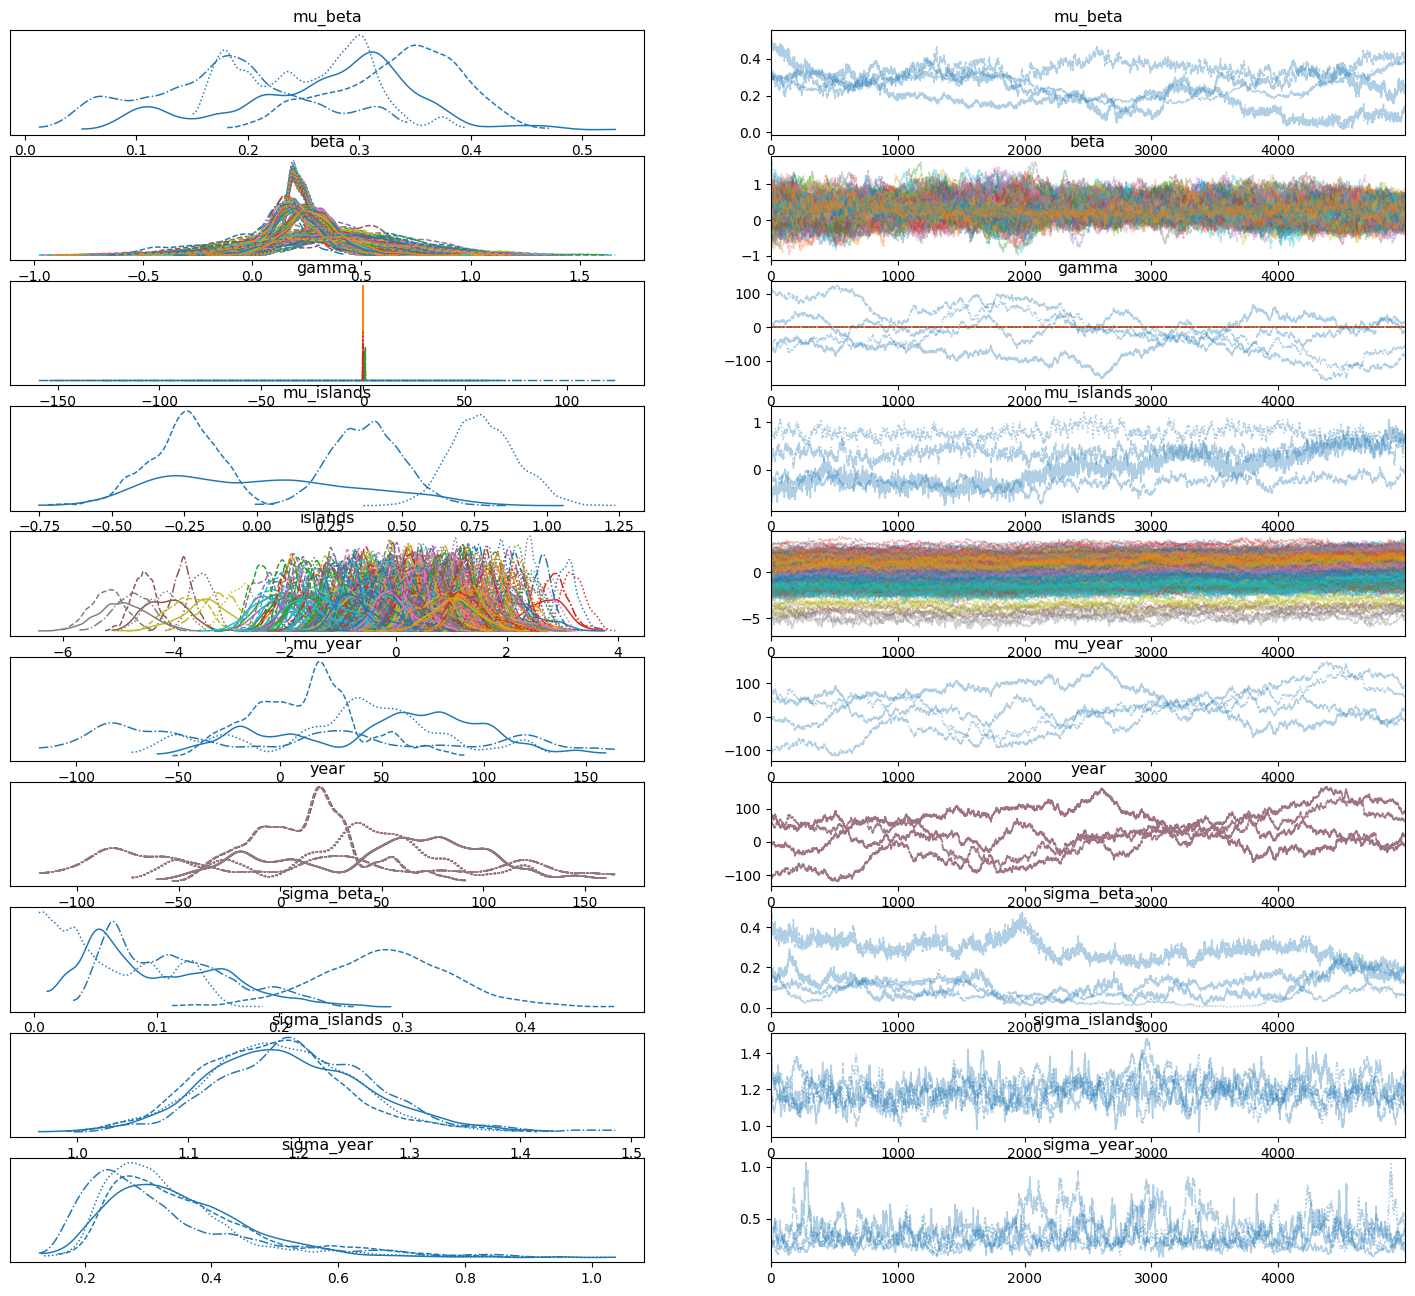

In [8]:
az.plot_trace(idata, figsize=(18, 16))  # サイズを調整
az.summary(idata)

# 橋ダミーのパラメータが0以上である確率

In [6]:
beta_bridge_samples = idata.posterior.beta[1]

prob_beta_bridge_positive = np.mean(beta_bridge_samples >= 0)

print(f"P(beta_1 >= 0) = {prob_beta_bridge_positive:.4f}")

P(beta_1 >= 0) = 0.3937


## 事後予測分布

In [63]:
with model:
    pm.sample_posterior_predictive(idata, extend_inferencedata=True)

Sampling: [y_obs]


Output()

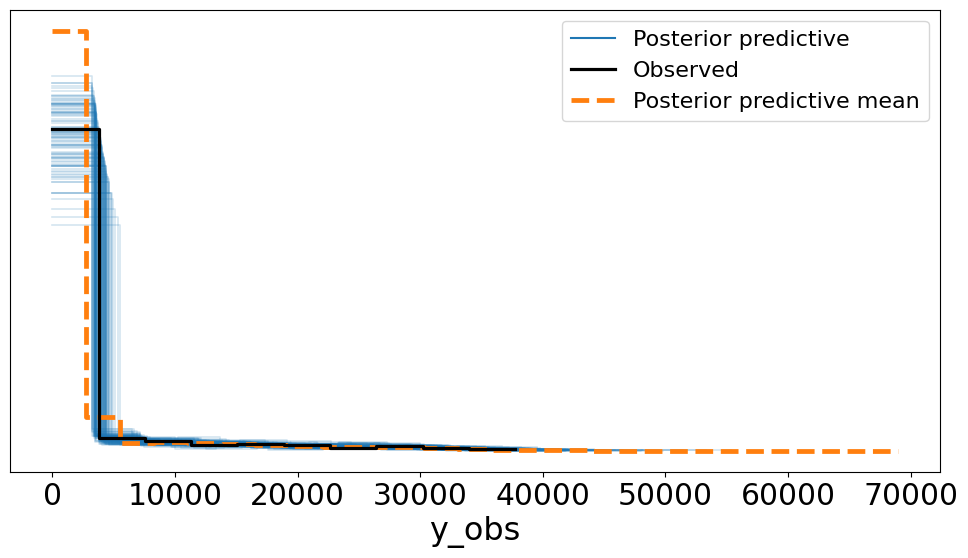

In [73]:
az.plot_ppc(idata, num_pp_samples=100, figsize=(12, 6))
plt.show()

## ATEの事後分布

In [12]:
posterior_beta = idata.posterior['beta']

posterior_df = pd.DataFrame({'beta': posterior_beta.values.flatten()})

plt.figure(figsize=(12, 6))
posterior_beta.boxplot()

AttributeError: 'DataArray' object has no attribute 'boxplot'

<Figure size 1200x600 with 0 Axes>